# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv('../../../access.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url).json() 

# btc_response_data
btc_price = btc_response_data['data']['1']['quotes']['USD']['price']
# print(btc_price)

# Fetch current ETH price
eth_response_data = requests.get(eth_url).json()

# eth_response_data
eth_price = eth_response_data['data']['1027']['quotes']['USD']['price']
# print(eth_price)

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth
                
# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $35775.60
The current value of your 5.3 ETH is $10064.70


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")


In [8]:
# Format current date as ISO format
today = pd.Timestamp("2023-07-14",tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df
df_portfolio
                     
# Reorganize the DataFrame

# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# # Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# # Preview DataFrame
df_portfolio

AGG                                            \
                            open   high    low  close   volume trade_count   
timestamp                                                                    
2023-07-14 04:00:00+00:00  98.23  98.31  97.92  97.94  7208357       21903   

                                          SPY                          \
                                vwap     open    high     low   close   
timestamp                                                               
2023-07-14 04:00:00+00:00  98.096753  450.475  451.36  448.49  449.28   

                                                             
                             volume trade_count        vwap  
timestamp                                                    
2023-07-14 04:00:00+00:00  69730670      484025  449.818675

In [9]:
# Pick AGG and SPY close prices
df_closing_prices = pd.DataFrame()

df_closing_prices['AGG'] = df_portfolio['AGG']['close']
df_closing_prices['SPY'] = df_portfolio['SPY']['close']

df_closing_prices.index = df_closing_prices.index.date
agg_close_price = df_closing_prices['AGG'][0]
spy_close_price = df_closing_prices['SPY'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $97.94
Current SPY closing price: $449.28


In [10]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22464.00
The current value of your 200 AGG shares is $19588.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto_wallet = round(my_eth_value + my_btc_value,2)
stock_and_bonds = round(my_spy_value + my_agg_value,2)
savings_data = [crypto_wallet, stock_and_bonds]

# Create savings DataFrame
df_savings_col = ['amount']
df_savings_rows = ['crypto','shares']
df_savings = pd.DataFrame(savings_data,index=df_savings_rows, columns=df_savings_col)

# Display savings DataFrame
display(df_savings)

,amount
crypto,45840.3
shares,42052.0


<Axes: title={'center': 'Composition of Personal Savings'}, ylabel='amount'>

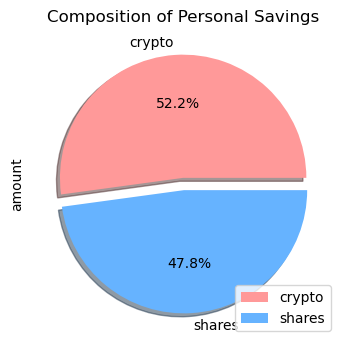

In [12]:
# Plot savings pie chart
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
df_savings.plot.pie(title='Composition of Personal Savings', y='amount',figsize=(4, 4),autopct='%1.1f%%', shadow=True, explode=[0.05, 0.05], colors=colors)


In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
current_savings = sum(savings_data)

# Validate saving health
if current_savings > emergency_fund:
    print("Congratulations on having more than enough money in your emergency fund.")
elif current_savings == emergency_fund:
    print("Congratulations on reaching this financial goal of saving just enough for your emergency fund.") 
elif current_savings < emergency_fund:
          savings_shortfall = round(emergency_fund - current_savings,2)
          print(f"Your are ${savings_shortfall} away from reaching your emergency fund savings goal.")

Congratulations on having more than enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# Set the tickers
tickers = ["AGG", "SPY"]

timeframe = "1Day"

df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df
df_stock_data
                     
# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)

# # Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-05-02 04:00:00+00:00       15119  110.627199  206.92  208.18  206.41   
2016-05-03 04:00:00+00:00       15662  110.865995  206.52  206.80  205.28   
2016-05-04 04:00:00+00:00       13982  110.879063  204.99  205.85  204.42   
2016-05-05 04:00:00+00:00       15707  111.028363  205.56  205.98  204.47   
2016-05-06 04:00:00+00:00       12697  111.031967  204.08  205.77  203.88   

                                                                        
                              close     volume trade_count        vwap  
timestamp                                                               
2016-05-02 04:00:00+00:00  207.9700   61908515      263580  207.294812  
2016-05-03 04:00:00+00:00  206.1592  106422142      377518  206.312060  
2016-05-04 04:00:00+00:00  205.0100   92199810      345261  205.090172  
2016-05-05 04:00:00+00:00  204.9700   67597222      280622  205.141555  
2016-05-06 04:00:00+00:00  205.7200   89131004      340335  204.937074

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days= 252*30
)

In [17]:
# Printing the simulation input data
MC_thirty_years.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.92   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001853  206.52   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  204.99   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.56   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.08   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  208.18  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.7200   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.008707  
2016-05-04 04:00:00+00:00  205.090172    -0.005574  
2016-05-05 04:00:00+00:00  205.141555    -0.000195  
2016-05-06 04:00:00+00:00  204.937074     0.003659

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995453,1.000532,1.001973,0.996106,0.997262,1.004263,1.010955,1.004940,1.002513,1.007059,...,0.996079,0.997269,1.002708,1.008631,0.996309,0.997919,1.005513,0.992018,1.006947,0.994159
2,0.995740,1.005057,0.997194,0.996390,0.997821,1.004346,1.007662,0.998351,0.993303,1.007832,...,0.999200,0.995551,1.000532,1.011564,1.004381,1.001590,1.004282,0.986722,1.014667,0.993857
3,0.992823,0.997418,0.995053,0.995315,1.007516,1.004782,1.006921,0.995147,0.991796,1.019675,...,0.997277,0.993624,1.000717,1.013879,1.000881,1.003882,1.006739,0.979530,1.015279,0.989573
4,0.988361,0.993182,0.985548,0.986841,1.011181,1.011441,1.011922,0.994332,0.983727,1.016166,...,1.003508,0.995250,1.002688,1.008973,1.006089,0.997674,1.004624,0.979390,1.012101,0.990666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.427701,9.936226,8.473024,6.379372,7.028337,5.286868,3.301289,4.774884,5.646789,7.041066,...,9.496399,9.935782,13.158239,5.686841,10.436030,8.346191,10.434954,5.252735,8.543245,5.612200
7557,5.440222,9.954309,8.436724,6.346868,7.025995,5.264631,3.307427,4.749156,5.663148,7.076123,...,9.541864,10.037978,13.237180,5.700455,10.388103,8.396095,10.502342,5.273897,8.488535,5.616218
7558,5.458754,10.035741,8.512271,6.385762,6.997733,5.285035,3.306627,4.739593,5.637237,7.104840,...,9.631704,10.139157,13.153375,5.685396,10.362361,8.358272,10.598825,5.285793,8.453930,5.658458
7559,5.496187,10.091462,8.502227,6.317457,6.934152,5.250803,3.306331,4.768120,5.621657,7.109932,...,9.662875,10.174203,13.146964,5.655740,10.420827,8.336901,10.614970,5.285013,8.517148,5.686196


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

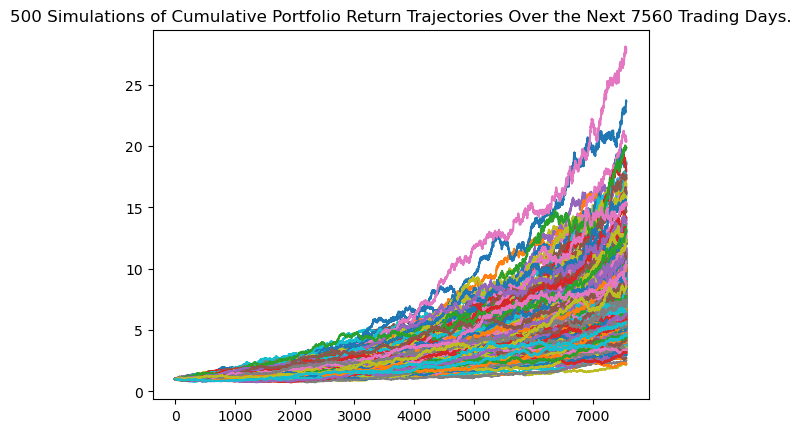

In [19]:
# Plot simulation outcomes
line_plot = MC_thirty_years.plot_simulation()
line_plot

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

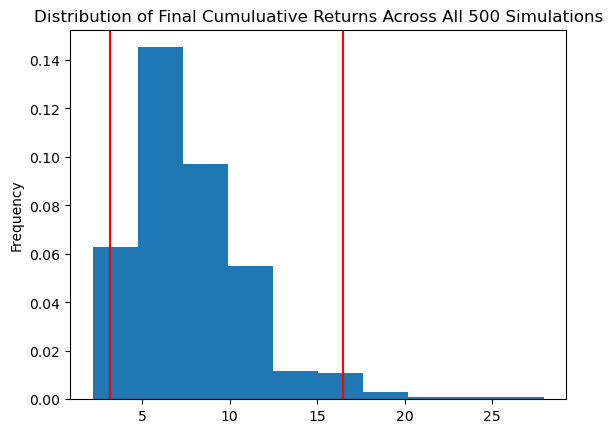

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirty_years.plot_distribution()
dist_plot

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirty_years.summarize_cumulative_return()
# Print summary statistics
print(tbl)

count           500.000000
mean              7.753665
std               3.379408
min               2.190962
25%               5.334437
50%               7.047348
75%               9.483225
max              27.937870
95% CI Lower      3.163343
95% CI Upper     16.487315
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8] * initial_investment,2)
ci_upper = round(tbl[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $63266.85 and $329746.31


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8] * initial_investment,2)
ci_upper = round(tbl[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $94900.28 and $494619.46


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days= 252*5
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_years.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.92   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001853  206.52   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  204.99   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.56   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.08   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  208.18  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.7200   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.008707  
2016-05-04 04:00:00+00:00  205.090172    -0.005574  
2016-05-05 04:00:00+00:00  205.141555    -0.000195  
2016-05-06 04:00:00+00:00  204.937074     0.003659

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

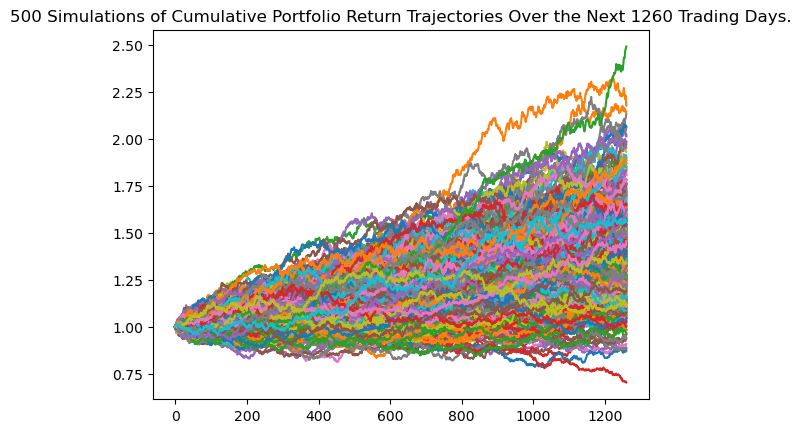

In [26]:
# Plot simulation outcomes
MC_five_years.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

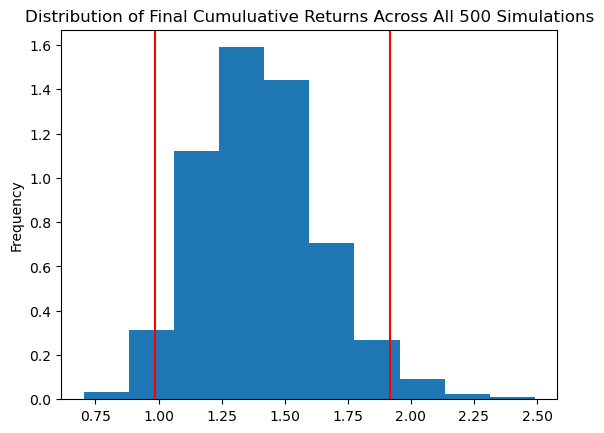

In [27]:
# Plot probability distribution and confidence intervals
dist_plot_five = MC_five_years.plot_distribution()
dist_plot_five

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_2 = MC_five_years.summarize_cumulative_return()
# Print summary statistics
print(tbl_2)

count           500.000000
mean              1.404228
std               0.243073
min               0.704501
25%               1.234486
50%               1.393003
75%               1.545735
max               2.491341
95% CI Lower      0.984607
95% CI Upper      1.918214
Name: 1260, dtype: float64


In [29]:
# Set initial investment
initial_investment_2 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_2[8] * initial_investment_2,2)
ci_upper_five = round(tbl_2[9] * initial_investment_2,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 5 years will end within in the range of $59076.42 and $115092.84


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days= 252*10
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_years.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.92   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001853  206.52   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  204.99   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.56   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.08   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  208.18  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.7200   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.008707  
2016-05-04 04:00:00+00:00  205.090172    -0.005574  
2016-05-05 04:00:00+00:00  205.141555    -0.000195  
2016-05-06 04:00:00+00:00  204.937074     0.003659

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

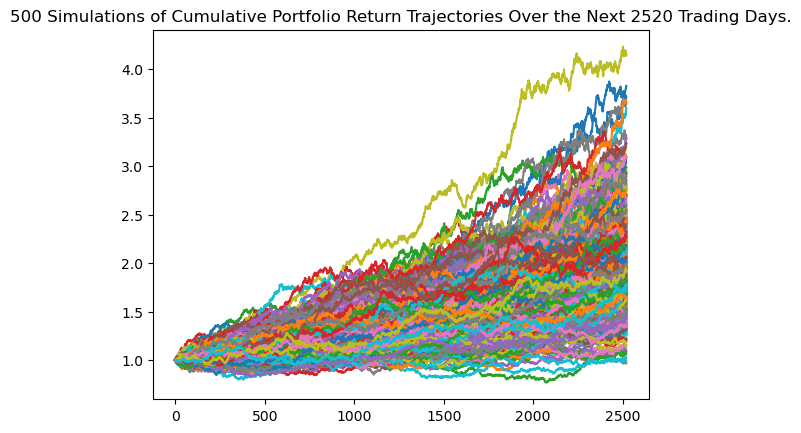

In [32]:
# Plot simulation outcomes
MC_ten_years.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

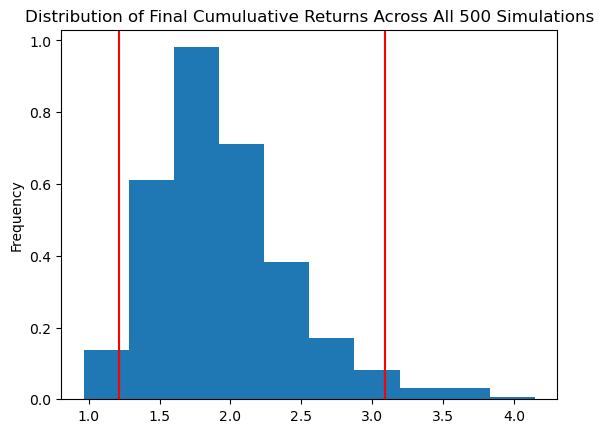

In [33]:
# Plot probability distribution and confidence intervals
dist_plot_ten = MC_ten_years.plot_distribution()
dist_plot_ten

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_1 = MC_ten_years.summarize_cumulative_return()

# Print summary statistics
print(tbl_1)

count           500.000000
mean              1.943373
std               0.484915
min               0.966351
25%               1.613182
50%               1.860469
75%               2.184403
max               4.147205
95% CI Lower      1.216042
95% CI Upper      3.088694
Name: 2520, dtype: float64


In [36]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl[8] * initial_investment,2)
ci_upper_ten = round(tbl[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $189800.56 and $989238.92
